# Toronto Words

Statistical analyses of [Centre for Medieval Studies](https://www.medieval.utoronto.ca/) Latin exams, by [Paul Langeslag](https://langeslag.uni-goettingen.de/).

In [1]:
import os,glob,re,json
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from statistics import fmean
from lexicalrichness import LexicalRichness
import matplotlib.pylab as plt
import numpy as np

First we'll define a number of functions we'll need later:

In [2]:
tokenizer = RegexpTokenizer(r'\w+')

normalization = [
    ("ę", "ae"),
    ("æ", "ae"),
    ("j", "i")
    ]

def normalize(string):
    # In addition to normalizing the above set, we'll print consonantal <u> as <v>:
    # TO DO: ensure reuuixit is correctly normalized without affecting Erkenuualdus
    for (k,v) in normalization:
        string = string.replace(k,v)
        string = re.sub('(?<=[aeiouy])u(?=[aeiouy])', 'v', string)
        string = re.sub('^u(?=[aeiouy])', 'v', string)
    return string    

# Strip an exam of its preamble and store exam identifier, passages, and their titles in a dict:
def isolate(doc):
    raw = open(doc).read()
    startpos = re.search('\n1\.\s*', raw).start()
    content = raw[startpos:]
    titles = []
    title_start_pos = []
    title_end_pos = []
    for i in range(1,5):
        # Store titles 1--4 in a list, and also remember their start and end indices;
        # those tell us where the text of the passages begins and ends, too:
        title = re.search(rf'(?<=\n){i}\.\ .*(?=\n)', content)
        titles.append(title.group(0))
        title_start_pos.append(title.start())
        title_end_pos.append(title.end())
    # Add a value of -1 to the list of start positions so the following loop works for the final text, too:
    title_start_pos.append(-1)
    # Now store the text of the four passages in a list:
    texts = []
    for i in range(0,4):
        texts.append(content[title_end_pos[i]:title_start_pos[i+1]].strip('\n '))
    exam = {}
    exam['id'] = doc.split('/')[1].removesuffix('.txt')
    exam['titles'] = titles
    exam['passages'] = texts
    return exam

# Run the above function on a corpus and return the result as a list:
def load_corpus(data_set):
    corpus = []
    for file in sorted(glob.glob('exams/{}*txt'.format(data_set))):
        corpus.append(isolate(file))
    return corpus

# Test for the existence of named-entities lists, else generate on the basis of capitalization and punctuation
# (this required me to tweak corpus capitalization in accordance with my particular NER specifications):
def ner_generate(data_sets):
    all_ner_lists = dict()
    for corpus in data_sets:
        if os.path.exists('ner_{}.json'.format(corpus[0])):
            entities = json.load(open('ner_{}.json'.format(corpus[0])))
        else:
            entities = []
            for exam in corpus[1]:
                tokens = word_tokenize(' '.join(exam['passages']))
                counter = 0
                for token in tokens:
                    if token[0].isupper():
                        if tokens[counter-1][-1].isalpha() or tokens[counter-1][-1] == ',':
                            entities.append(normalize(token.lower().strip('.')))
                    counter += 1
            entities = sorted(list(set(entities)))
            with open('ner_{}.json'.format(corpus[0]), 'w') as f:
                json.dump(entities, f)
        all_ner_lists[corpus[0]] = entities
    return all_ner_lists

# Count the number of verse passages per exam, using markdown manual line breaks as a proxy:
def verse_counter(data_sets):
    for corpus in data_sets:
        all_verse_index = dict()
        for corpus in data_sets:
            lengths = []
            verse_index = []
            for exam in corpus[1]:
                counter = 0
                for passage in exam['passages']:
                    manual_breaks = []
                    line_break_count = len(re.findall('\s\s\n', passage))
                    # Count a passage with manual line breaks as verse unless the exam contains a passage of chapter headings:
                    if line_break_count > 2 and not re.search('chapter headings', ' '.join(exam['titles']), re.IGNORECASE):
                        counter += 1
                        # Also keep track of the length of verse and prose passages so we can calculate a mean:
                        lengths.append((('verse'), len(tokenizer.tokenize(passage))))
                    else:
                        lengths.append((('prose'), len(tokenizer.tokenize(passage))))
                verse_index.append((exam['id'], counter))
            # For each level (corpus), the return value contains the verse counter per exam
            # as well as unlabelled lists on the lengths of verse and prose passages
            all_verse_index[corpus[0]] = (verse_index, lengths)
    return all_verse_index

# Count tokens per exam:
def exam_length(data_sets):
    length_all = dict()
    for corpus in data_sets:
        exams = []
        for exam in corpus[1]:
            all_passages = ' '.join(exam['passages'])
            tokens = tokenizer.tokenize(all_passages)
            length = (exam['id'], len(tokens))
            exams.append(length)
        length_all[corpus[0]] = exams
    return length_all

Now we can load our corpora and generate lists of proper nouns:

In [3]:
data_sets = (('l1', load_corpus('l1')), ('l2', load_corpus('l2')))
aliases = {'l1': 'Level One', 'l2': 'Level Two'}
ner = ner_generate(data_sets)

And with that, we can begin lining up some statistics. We can count tokens later; let's start with something a little more off the beaten track, the distribution of verse passages:

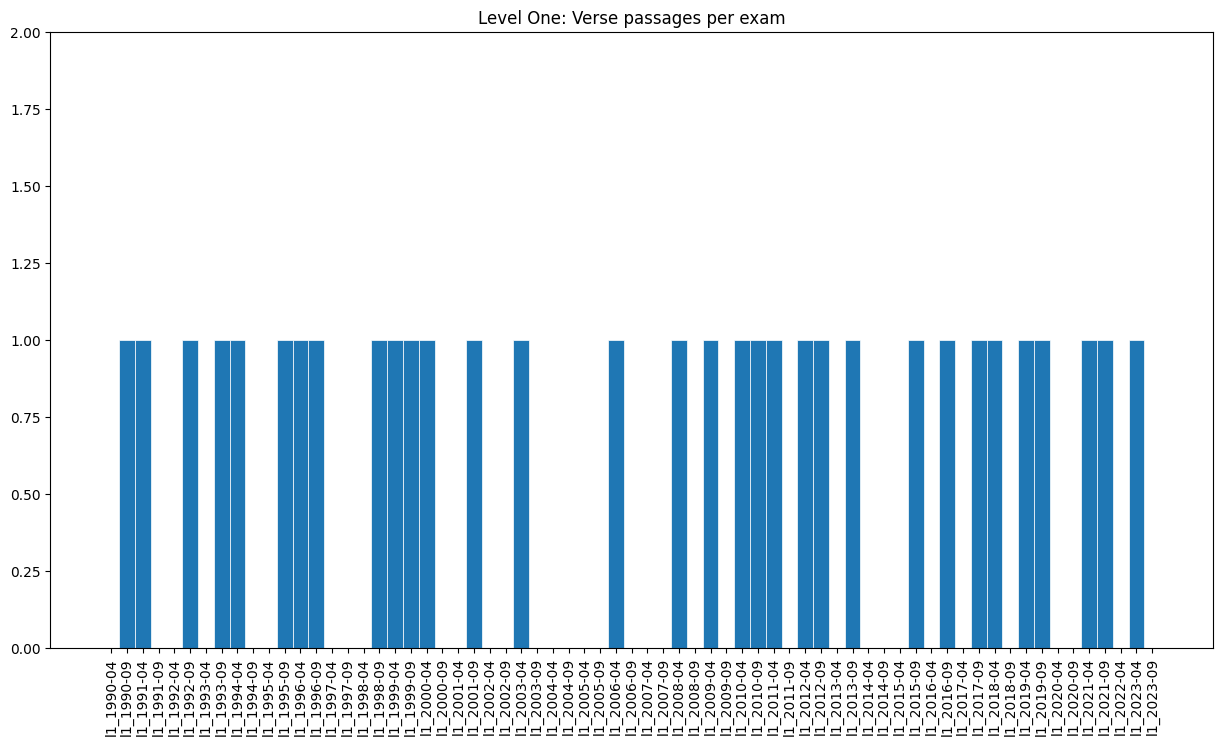

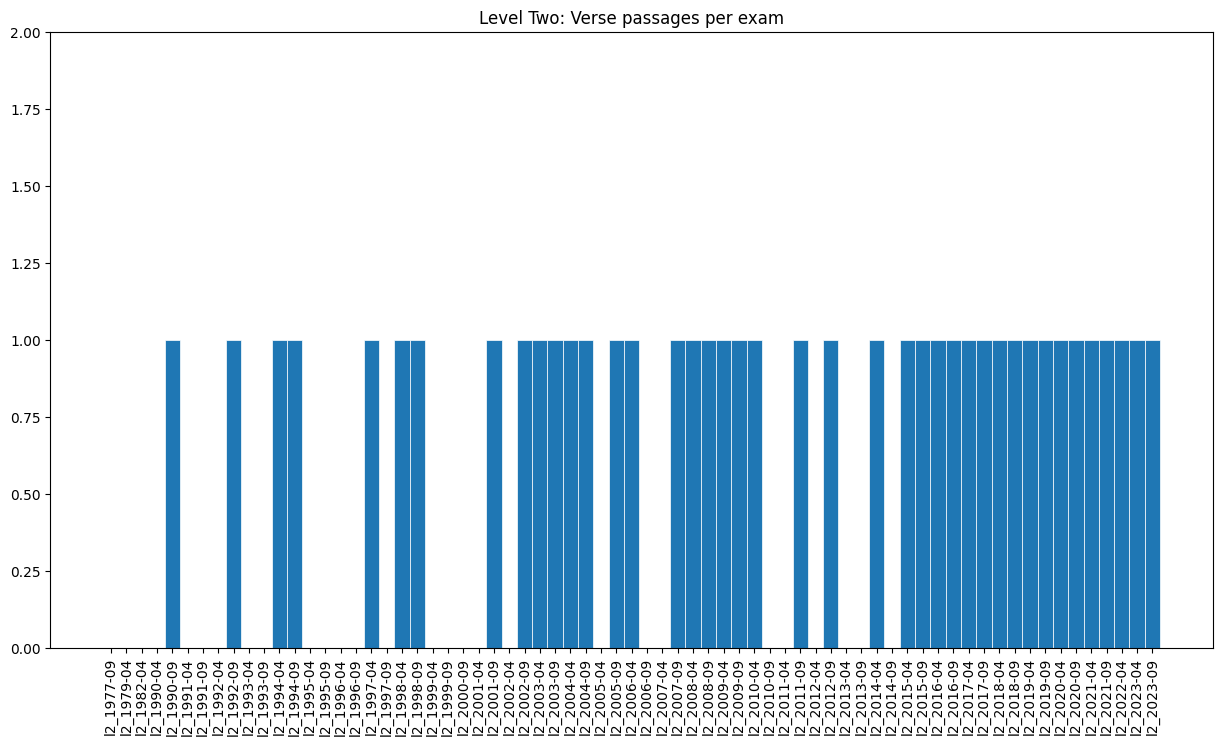

In [4]:
# Count the number of verse passages per exam:

verse_index = verse_counter(data_sets)
for corpus in data_sets:
    exams = list(zip(*verse_index[corpus[0]][0]))[0]
    hits = list(zip(*verse_index[corpus[0]][0]))[1]
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    plt.ylim(0,2)
    fig.set_size_inches(15,8)
    ax.set_title(aliases[corpus[0]] + ": Verse passages per exam")
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.bar(exams, hits, width=1, edgecolor="white", linewidth=0.5)

As we can see, in the 132 exams in our data set, there's never been one on either level that's had more than one verse passage, and they are more frequent for level two than one. On the other hand, the jump is only 22 percent, and the expectation that every level two exam must have a verse passage has only consistently held true since 2015. Our first evidence that this institution isn't as set in stone as CMS likes to suggest?

Now let's test for the length of exams:

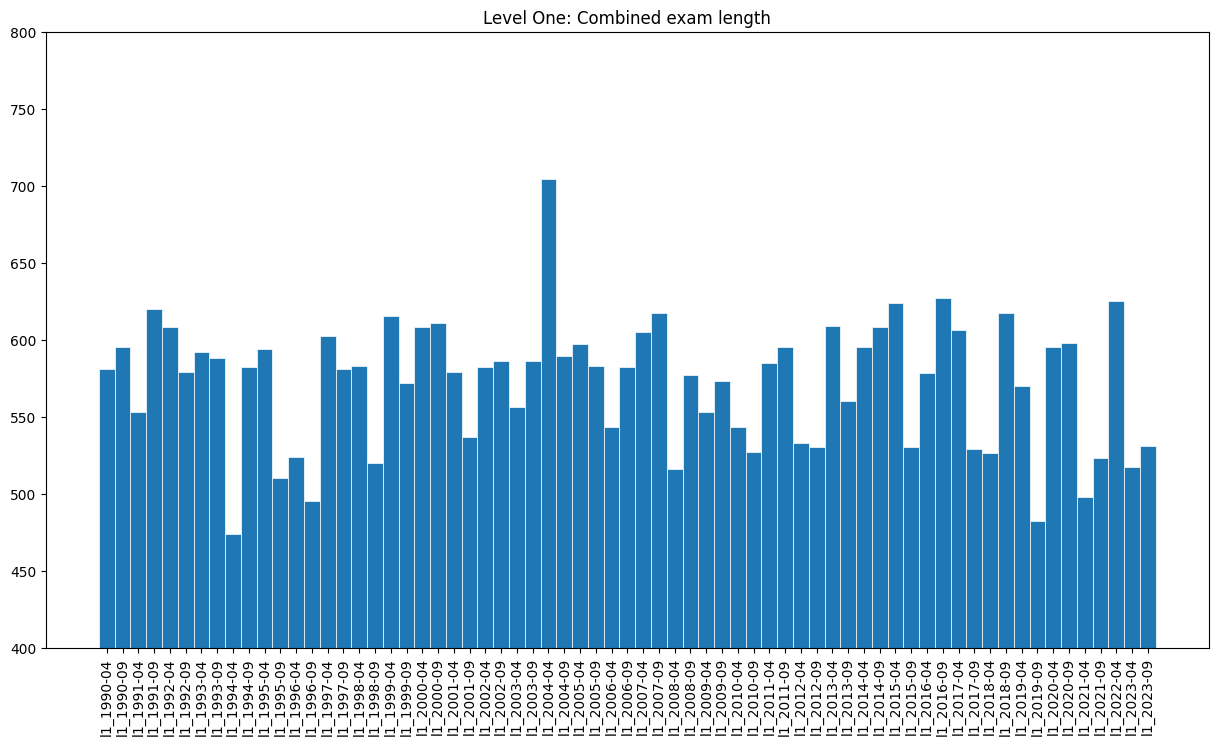

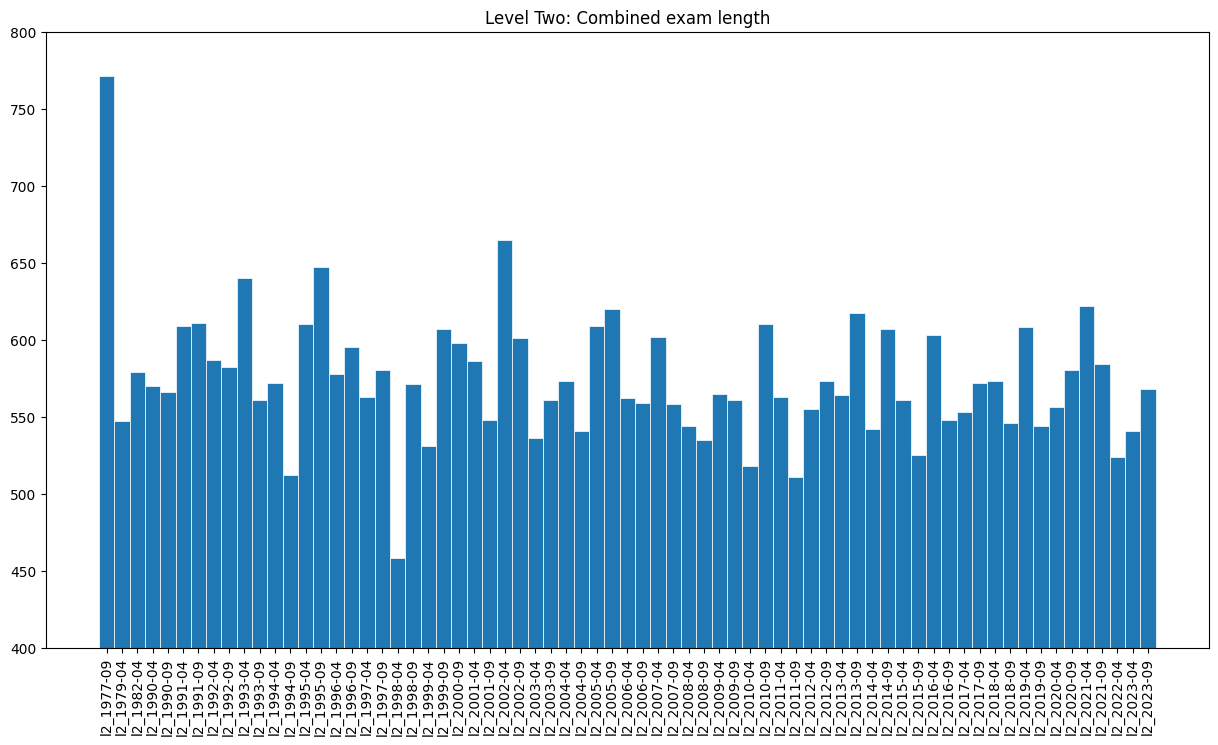

In [5]:
# Test for the length of exams:
length = exam_length(data_sets)
for corpus in data_sets:
    exams = list(zip(*length[corpus[0]]))[0]
    scores = list(zip(*length[corpus[0]]))[1]
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    plt.ylim(400,800)
    fig.set_size_inches(15,8)
    ax.set_title(aliases[corpus[0]] + ": Combined exam length")
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.bar(exams, scores, width=1, edgecolor="white", linewidth=0.5)

Outliers in terms of length are few, although that 1977 level two exam (signed `:CMM`) does stand out; also note the March 1998 exam for the same level, which includes a brief poem. Exam designers will have had an intuitive check on length in the tendency for exams to take up 2.5 letter-sized pages (three in the case of that 1977 exam), but poems need fewer words to take up the same space, which may help explain why recent level two exams are just a tad shorter on average. Let's try to get a handle on mean exam length:

In [6]:
# Measure the average length of all exams per level:
for corpus in data_sets:
    mean_length = round(fmean([y for x,y in length[corpus[0]]]))
    print('- The mean length of ' + aliases[corpus[0]] + ' exams is ' + str(mean_length) + ' words.')

- The mean length of Level One exams is 572 words.
- The mean length of Level Two exams is 574 words.


Surprisingly perhaps, the two levels do *not* differ in mean length; measured across the decades, level two exams are not shorter for more frequently including verse, raising the question whether verse passages are indeed equally long in token count as their prose counterparts. Let's compare:

In [7]:
for corpus in data_sets:
    mean_passage_length_prose = round(fmean([y for x,y in verse_index[corpus[0]][1] if x == 'prose']))
    mean_passage_length_verse = round(fmean([y for x,y in verse_index[corpus[0]][1] if x == 'verse']))
    print('- The mean length of ' 
          + aliases[corpus[0]] 
          + ' prose passages is ' 
          + str(mean_passage_length_prose) 
          + ' words.')
    print('- The mean length of ' 
          + aliases[corpus[0]] 
          + ' verse passages is ' 
          + str(mean_passage_length_verse) 
          + ' words.')

- The mean length of Level One prose passages is 148 words.
- The mean length of Level One verse passages is 103 words.
- The mean length of Level Two prose passages is 150 words.
- The mean length of Level Two verse passages is 110 words.


So if verse passages are forty to forty-five words shorter than prose passages of the same level, perhaps the mean length of all exams hides a difference in length between exams with and without verse:

In [8]:
for corpus in data_sets:
    mean_length_no_verse = round(fmean([y for x,y in length[corpus[0]] if dict(verse_index[corpus[0]][0])[x] < 1]))
    mean_length_verse = round(fmean([y for x,y in length[corpus[0]] if dict(verse_index[corpus[0]][0])[x] > 0]))
    print('- The mean length of ' 
          + aliases[corpus[0]] 
          + ' exams *without* verse passages is ' 
          + str(mean_length_no_verse) 
          + ' words.')
    print('- The mean length of ' 
          + aliases[corpus[0]] 
          + ' exams *with* verse passages is ' 
          + str(mean_length_verse) 
          + ' words.')

- The mean length of Level One exams *without* verse passages is 597 words.
- The mean length of Level One exams *with* verse passages is 544 words.
- The mean length of Level Two exams *without* verse passages is 598 words.
- The mean length of Level Two exams *with* verse passages is 558 words.


So there we have it, a forty-word verse relief for level two, and forty-five for level one, corresponding neatly to the difference in mean length between prose and verse passages. Keep in mind that's without discarding any of the outliers.

Of course, a short exam with many named entities gives less occasion for translation error. Let's see that length chart again, now after excluding named entities. I've isolated named entities with the help of capitalization and punctuation (see the `ner_generate()` function above), but I've manually modified the exams' capitalization to restrict named entities to proper nouns only, excluding adjectives like "Viennese" or "Roman" (even where used substantively) as well as the titles of works, reasoning that whereas all names are part of the translation task, book titles and demonyms are more so than personal and place names proper. For both nouns and adjectives, of course, this means that no distinction is made between well-known and lesser-known place names, so both the list of included forms and the list of excluded forms have members that would be easy to translate as well as ones that most students would have to guess at.

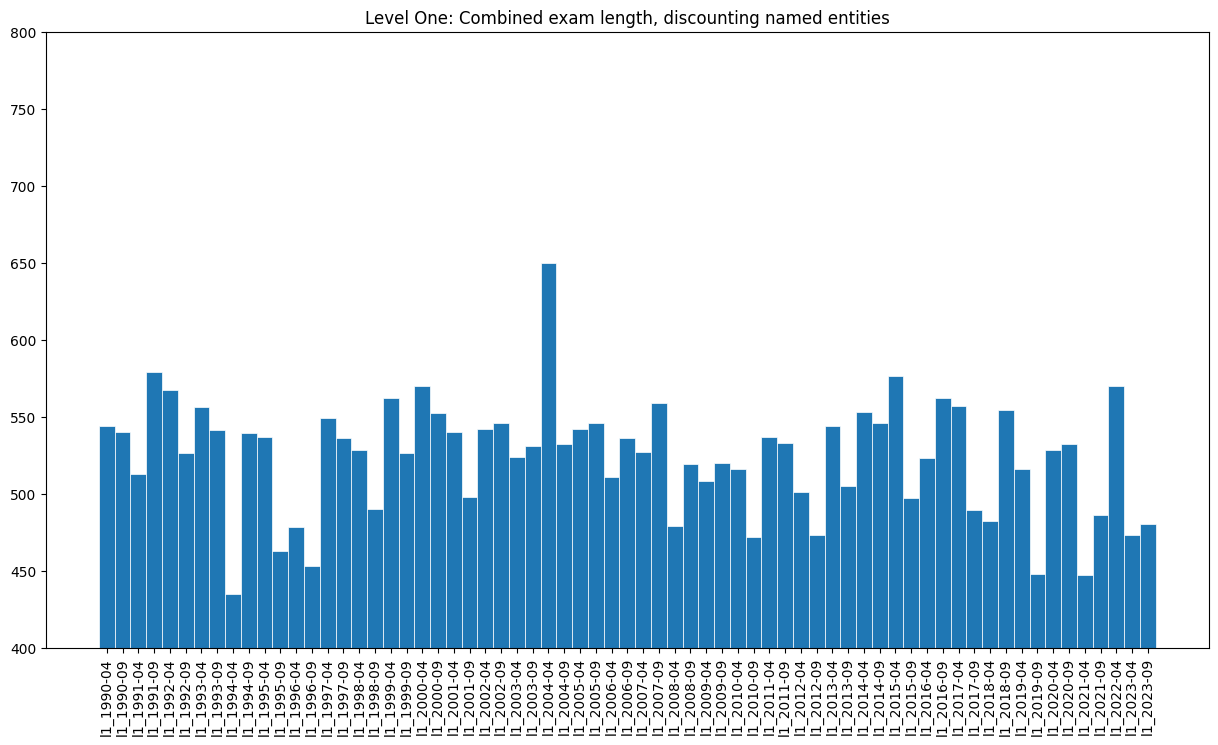

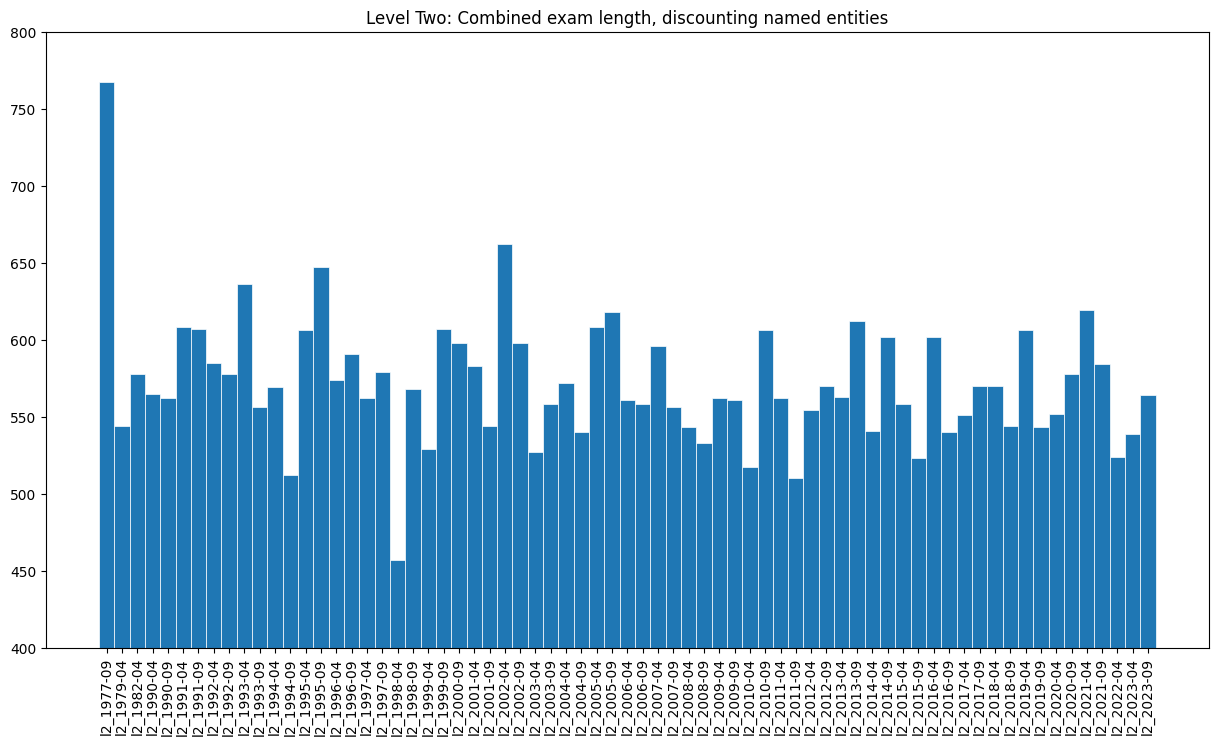

In [9]:
for corpus in data_sets:
    exams = []
    scores = []
    ner_count = []
    for exam in corpus[1]:
        all_passages = ' '.join(exam['passages'])
        tokens = tokenizer.tokenize(all_passages)
        tokens_bare = [token.lower() for token in tokens if not token in ner[corpus[0]]]
        length = len(tokens)
        length_without_ner = len(tokens_bare)
        ner_counter = length-length_without_ner
        ner_count.append(ner_counter)
        scores.append(length_without_ner)
        exams.append(exam['id'])
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    plt.ylim(400,800)
    fig.set_size_inches(15,8)
    ax.set_title(aliases[corpus[0]] + ": Combined exam length, discounting named entities")
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.bar(exams, scores, width=1, edgecolor="white", linewidth=0.5)

The difference may be easier to see if we count the number of discarded named entities per exam instead of their complement tokens:

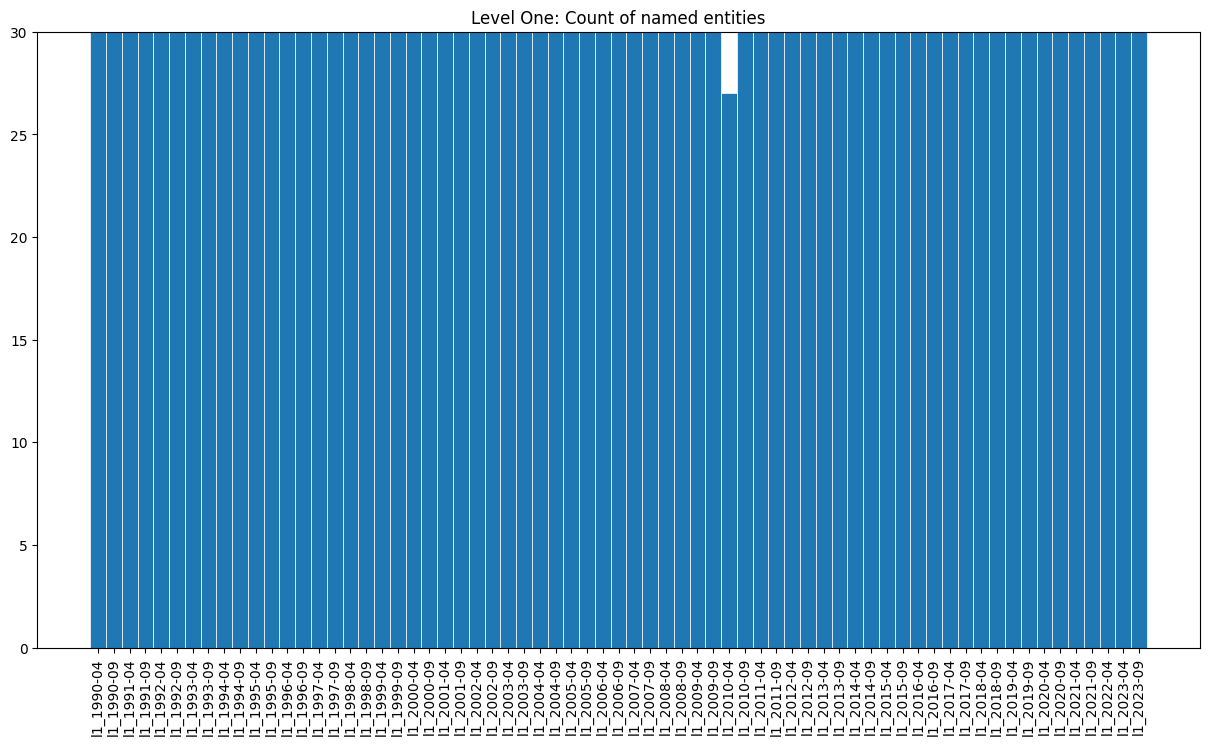

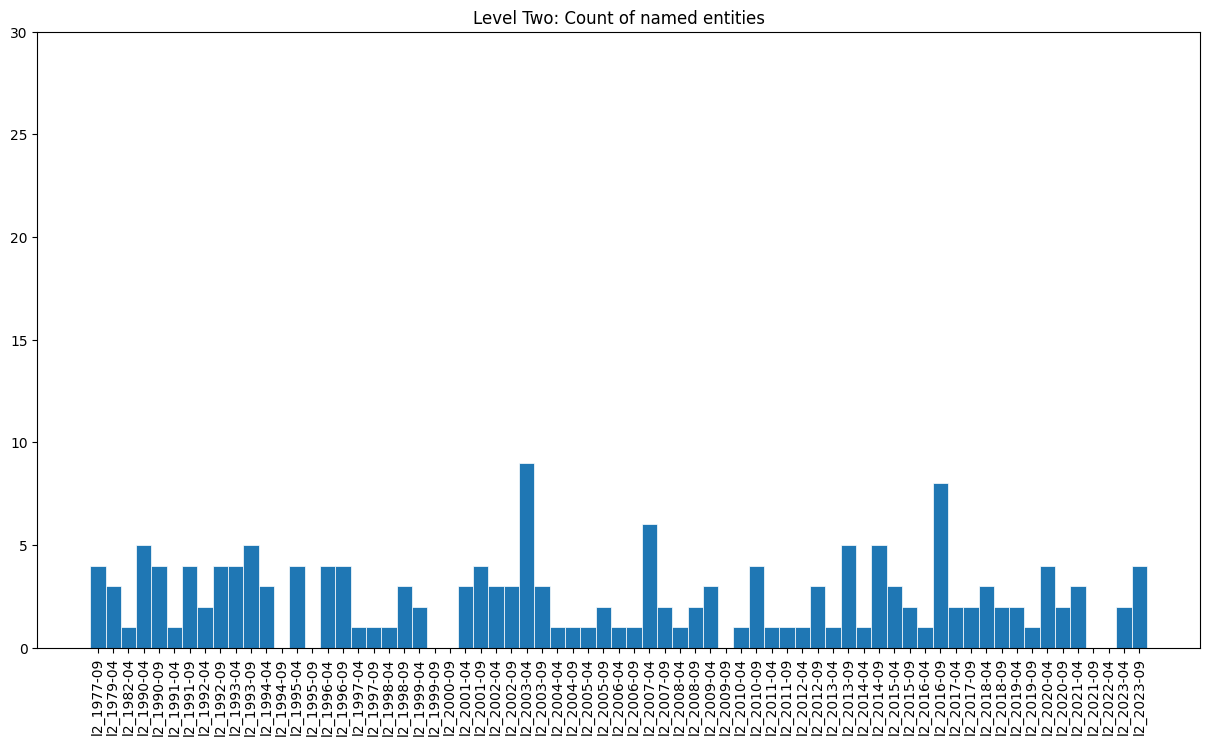

In [10]:
for corpus in data_sets:
    exams = []
    scores = []
    for exam in corpus[1]:
        all_passages = ' '.join(exam['passages'])
        tokens = tokenizer.tokenize(all_passages)
        tokens_bare = [token.lower() for token in tokens if not token in ner[corpus[0]]]
        length = len(tokens)
        length_without_ner = len(tokens_bare)
        ner_counter = length-length_without_ner
        scores.append(ner_counter)
        exams.append(exam['id'])
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    plt.ylim(0,30)
    fig.set_size_inches(15,8)
    ax.set_title(aliases[corpus[0]] + ": Count of named entities")
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.bar(exams, scores, width=1, edgecolor="white", linewidth=0.5)

That's an interesting pattern: an exam's perceived difficulty (i.e. the level at which it is set) is inversely correlated with its tendency to name drop. Of course between two equally long texts, a larger proportion of proper nouns makes fewer demands on the translator's passive vocabulary, and texts containing many names may also tend to be more narrative in character, perhaps making them more predictable or relatable.

And that 1995 level one exam with nearly sixty names? Just a perfect storm of an exam containing a name-dropping anecdote, an Old Testament narrative, and a commentary on the same narrative. All those names, and a reuse of context, too? Those folks had it too easy.

Next, let's take the temperature of the exams' lexical richness, or lexical diversity. There's a range of different ways of measuring it, but it always comes down to a variation on the token-type ratio (TTR). Let's use MTLD (the _measure of textual lexical diversity_), which is a bit more sophisticated inasmuch as it measures each token's TTR for the text up to that point, but starting from the last point a preset value was reached ([McCarthy and Jarvis 2010](https://link.springer.com/content/pdf/10.3758/BRM.42.2.381.pdf)). This metric suggests striking variation:

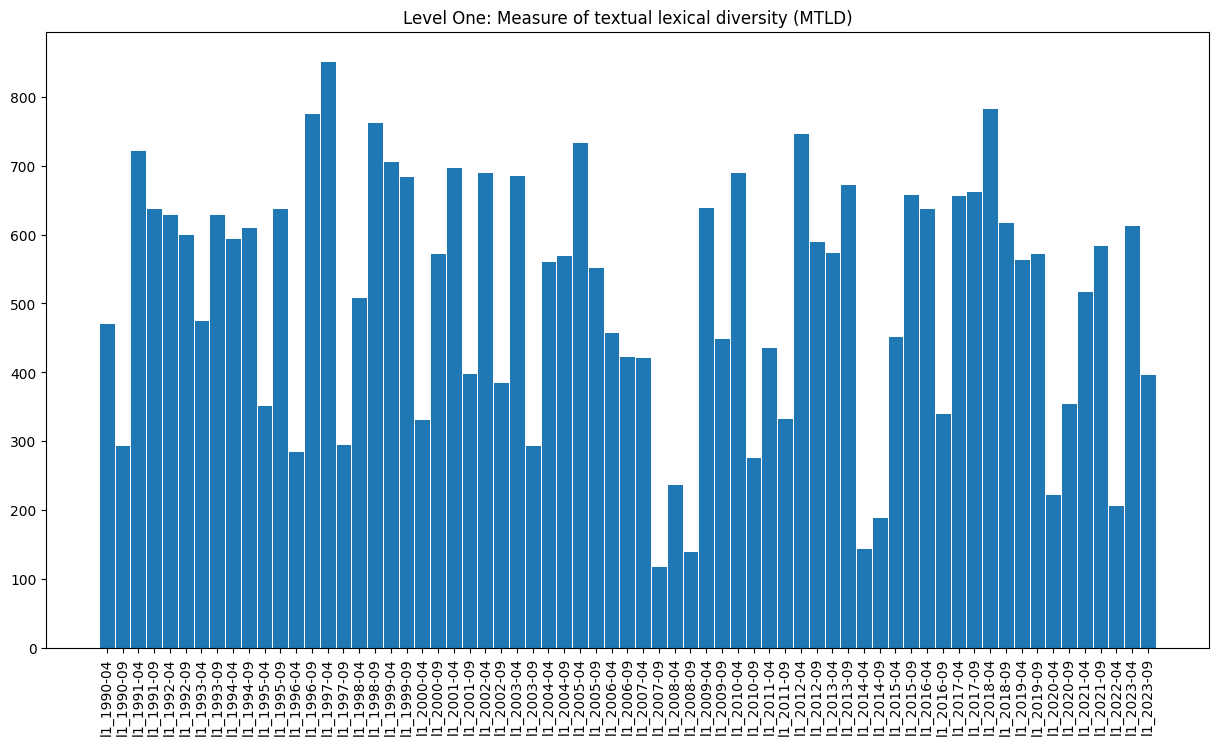

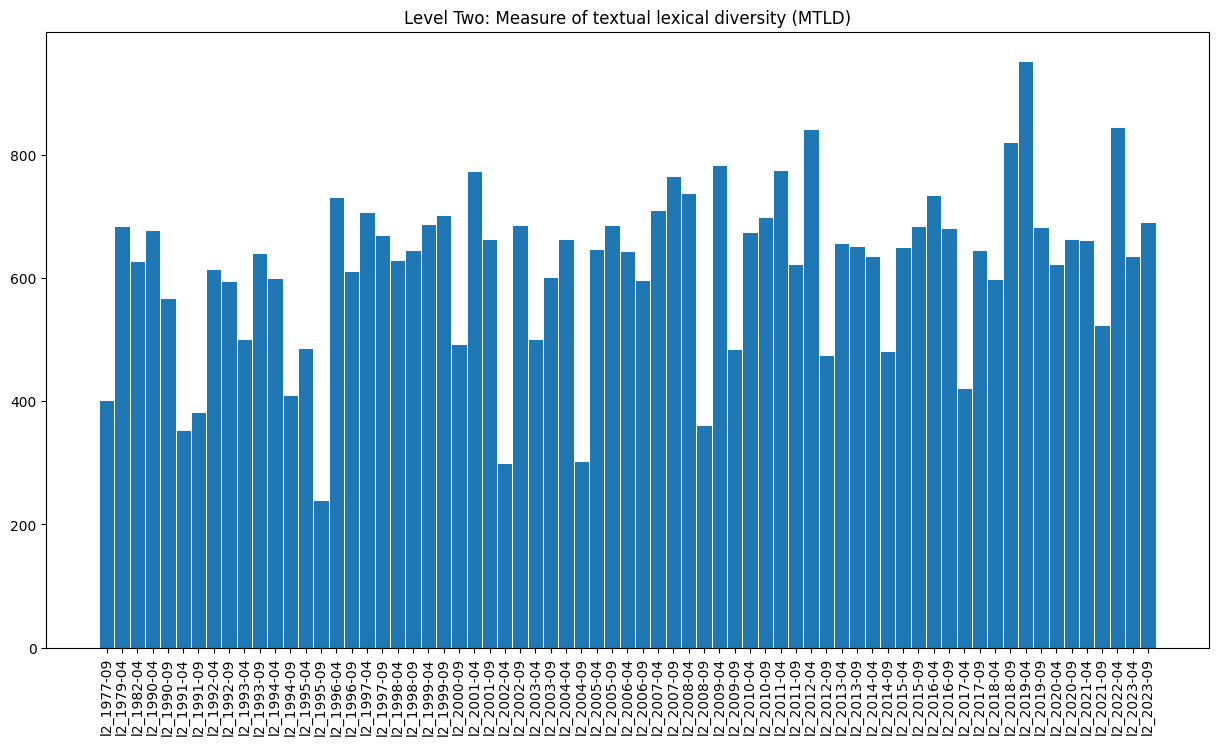

In [11]:
for corpus in data_sets:
    exams = []
    scores = []
    for exam in corpus[1]:
        all_passages = ' '.join(exam['passages'])
        tokens = tokenizer.tokenize(all_passages)
        tokens_bare = [token.lower() for token in tokens if not token in ner[corpus[0]]]
        lex = LexicalRichness(tokens_bare, tokenizer=None)
        exams.append(exam['id'])
        scores.append(lex.mtld())
    fig, ax = plt.subplots()
    plt.xticks(rotation=90)
    fig.set_size_inches(15,8)
    ax.set_title(aliases[corpus[0]] + ": Measure of textual lexical diversity (MTLD)")
    ax.tick_params(axis='x', which='major', labelsize=10)
    ax.bar(exams, scores, width=1, edgecolor="white", linewidth=0.7)

In [12]:
# TODO: take the mean diversity of each level. Maybe also of verse vs prose passages.

Keep in mind: none of the above statistics say a whole lot about the relative *difficulty* of the different exams or the consistency of their difficulty over time, as that ultimately depends on their grading.